## Inference and submission
Now, we have trained model ([train with livecell](https://www.kaggle.com/markunys/sartorius-transfer-learning-train-with-livecell), [train](https://www.kaggle.com/markunys/sartorius-transfer-learning-train)). Let's inference with the model !!

In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272235 sha256=4814eeb6724956144fb2f82616faab625dc39c0feb18e0fae9f36e8f40fdd9d3
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [2]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *
import pycocotools.mask as mask_util
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')

In [4]:
ids, masks=[],[]
test_names = (dataDir/'test').ls()

### Initiate a Predictor from our trained model

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
#NEW 
# cfg.ROI_HEADS.NMS_THRESH_TEST = 0.05
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.WEIGHTS = '../input/stage2-model-best-256-map-0-272/stage2_model_best_256_map_0_272.pth'  
# cfg.MODEL.WEIGHTS = '../input/stage2-model-best-256-map-0-272/stage2_iter4355_map_0_273.pth'  
# cfg.MODEL.WEIGHTS = '../input/stage2-model-best-256-map-0-272/mosaic_X101_map_0_246.pth'  


cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
# [shsy5y, astro, cort]: It makes perfect sense to use lower thresholds on shsy5y and astro 
# because shsy5y cell lines have lots of object and astro cell lines have very large objects.
THRESHOLDS = [.15, .35, .55]
# THRESHOLDS = [.53, .45, .55]
MIN_PIXELS = [75, 150, 75] # <--------------------- need to tune

# Helper Functions

In [6]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSIFIER_CHK = '../input/efficientnetv2classifiersartorious/EfficientNetV2-Classifier-finetuned-epoch19.pth'

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

IMAGE_RESIZE = (520, 520)
CELL_TYPES  = {0: 'shsy5y', 1: 'astro', 2: 'cort'}
# Get the input of the classifier
def get_image_for_classifier(image):
    transforms = A.Compose([A.Resize(IMAGE_RESIZE[0], IMAGE_RESIZE[1]), 
                            A.Normalize(mean=RESNET_MEAN, std=RESNET_STD, p=1), 
                            ToTensorV2()])
    image = transforms(image=image)['image']
    return image.unsqueeze(0).to(DEVICE)

# Assess the image_id cell_type with the classifier
def get_image_cell_type(classifier, image):
    img = get_image_for_classifier(image)
    with torch.no_grad():
        img.cuda()
        logits = classifier(img)[0]
        cell_type_idx = torch.argmax(logits).item()
    return cell_type_idx

classifier = timm.create_model('efficientnetv2_rw_m', pretrained=False, num_classes=3)
classifier.load_state_dict(torch.load(CLASSIFIER_CHK))
classifier.cuda()
# classifier.to(DEVICE)
classifier.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): Identity()
        (conv_pwl): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EdgeResidual(
        (conv_exp): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): I

# REFINE by pre_classifer_class

In [7]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)
    pred_classifer_class = get_image_cell_type(classifier, im)
        
    take = (pred['instances'].scores >= THRESHOLDS[pred_classifer_class]) * (pred['instances'].pred_classes == pred_classifer_class)
#     print("take", take)
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int)
#     print(pred)
    for mask in pred_masks:
        mask = mask * (1 - used)
        if mask.sum() >= MIN_PIXELS[pred_classifer_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

### Look at the outputs on a sample test file to sanity check
I'm encoding here in the competition format and decoding back to bit mask just to make sure everything is fine

In [8]:
encoded_masks = get_masks(test_names[0], predictor)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


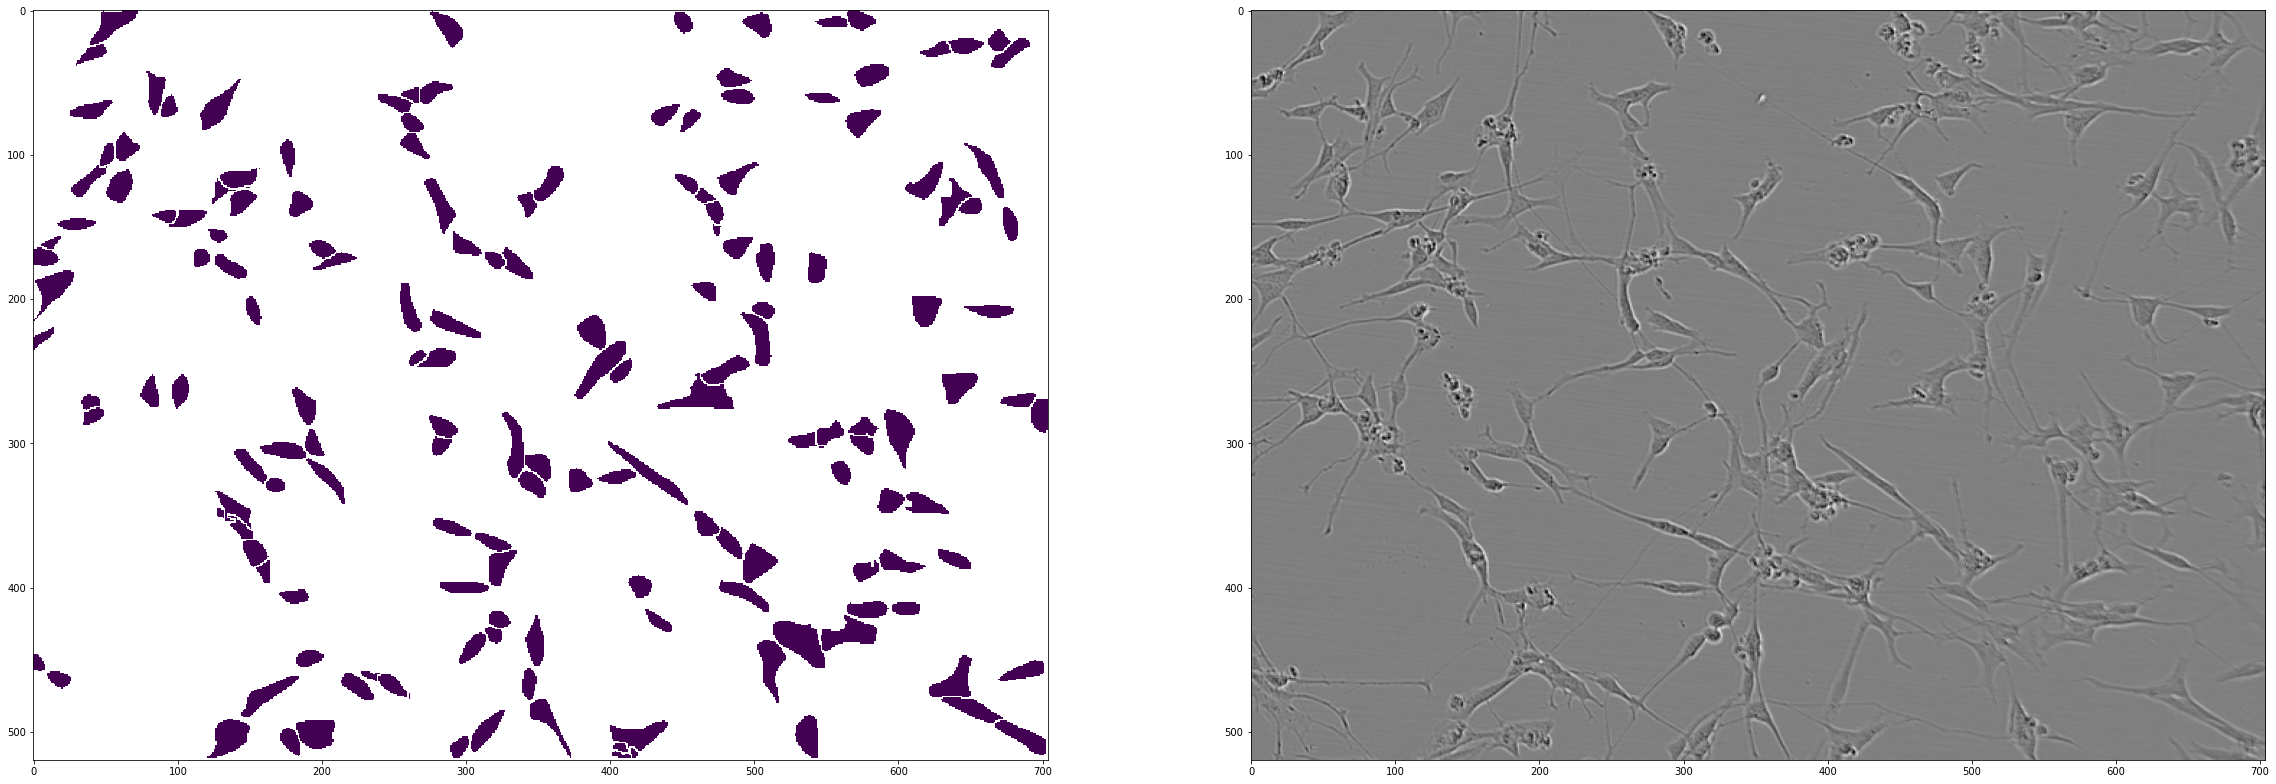

In [9]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

In [10]:
encoded_masks

['140002 18 140706 21 141410 22 142114 22 142818 22 143522 22 144226 21 144931 20 145635 19 146339 19 147043 18 147747 18 148451 18 149155 17 149859 17 150564 16 151268 15 151972 15 152677 13 153382 12 154087 10 154792 7 155499 1',
 '96418 4 97121 6 97825 7 98529 8 99233 9 99937 9 100641 10 101345 10 102049 11 102753 11 103457 12 104161 12 104865 12 105569 12 106274 11 106978 11 107682 11 108387 10 109091 10 109795 10 110500 9 111204 8 111909 7 112613 6 113318 4',
 '1150 8 1854 9 2557 11 3261 12 3965 13 4669 13 5373 13 6077 14 6782 13 7486 13 8191 12 8895 12 9600 11 10305 9 11009 8 11715 3',
 '177491 2 178194 4 178897 5 179600 6 180303 7 181007 7 181710 8 182414 9 183117 10 183821 10 184524 12 185228 12 185932 12 186635 13 187339 14 188043 14 188747 14 189452 13 190157 12 190862 11 191567 10 192272 9 192977 8 193682 6',
 '224280 8 224979 15 225680 20 226381 23 227083 25 227785 27 228488 27 229192 24 229897 21 230603 17 231311 11',
 '139542 4 140245 6 140948 8 141652 8 142356 9 143060 9

### Looks good, so lets generate masks for all the files and create a submission

In [11]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

In [12]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,140002 18 140706 21 141410 22 142114 22 142818...
1,7ae19de7bc2a,96418 4 97121 6 97825 7 98529 8 99233 9 99937 ...
2,7ae19de7bc2a,1150 8 1854 9 2557 11 3261 12 3965 13 4669 13 ...
3,7ae19de7bc2a,177491 2 178194 4 178897 5 179600 6 180303 7 1...
4,7ae19de7bc2a,224280 8 224979 15 225680 20 226381 23 227083 ...
